<a href="https://colab.research.google.com/github/lukmanfash/lukmanfash/blob/main/Landsat__Surf_Water_Dynamics_Analy_TN_(mNDWI_1)_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## mNDWI_1: 
Data: Landsat

MNDWI1 = (Green − SWIR1)/(Green + SWIR1)

In [ ]:
import ee
import geemap

In [ ]:
Map = geemap.Map()

In [ ]:
roi = ee.FeatureCollection('TIGER/2018/States').filter(
    ee.Filter.eq('NAME', 'Tennessee')
)
Map.addLayer(roi, {}, "TN")
Map.centerObject(roi, 7)

In [ ]:
images = geemap.landsat_timeseries(
    roi=roi, start_year=2010, end_year=2020, start_date='01-01', end_date='12-31'
)

In [ ]:
first = images.first()

vis_params = {'bands': ['NIR', 'Red', 'Green'], 'min': 0, 'max': 3000}

Map.addLayer(first, vis_params, 'First image')

In [ ]:
ndwi_images = images.map(
    lambda img: img.normalizedDifference(['Green', 'SWIR1']).rename('ndwi')
)

ndwi_palette = [
    '#ece7f2',
    '#d0d1e6',
    '#a6bddb',
    '#74a9cf',
    '#3690c0',
    '#0570b0',
    '#045a8d',
    '#023858',
]

first_ndwi = ndwi_images.first()

Map.addLayer(first_ndwi, {'palette': ndwi_palette}, 'First NDWI')

In [ ]:
water_images = ndwi_images.map(lambda img: img.gt(0).selfMask())

first_water = water_images.first()

Map.addLayer(first_water, {'palette': ['blue']}, 'First Water')

In [ ]:
def cal_area(img):
    pixel_area = img.multiply(ee.Image.pixelArea()).divide(1e6)
    img_area = pixel_area.reduceRegion(
        **{
            'geometry': roi.geometry(),
            'reducer': ee.Reducer.sum(),
            'scale': 1000,
            'maxPixels': 1e12,
        }
    )
    return img.set({'water_area': img_area})

In [ ]:
water_areas = water_images.map(cal_area)

In [ ]:
water_stats = water_areas.aggregate_array('water_area').getInfo()
water_stats

[{'ndwi': 549.5036698901957},
 {'ndwi': 543.9970368850489},
 {'ndwi': 416.7542359394612},
 {'ndwi': 530.2424994296571},
 {'ndwi': 548.6764446129903},
 {'ndwi': 493.8360732681375},
 {'ndwi': 478.4144406132354},
 {'ndwi': 460.56107135661813},
 {'ndwi': 561.4288491311275},
 {'ndwi': 595.8834791791671},
 {'ndwi': 566.9931164911771}]

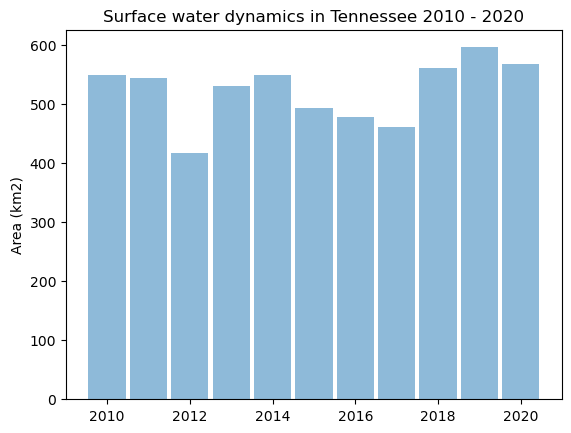

In [ ]:
import matplotlib.pyplot as plt

x = list(range(2010, 2021))
y = [item.get('ndwi') for item in water_stats]

plt.bar(x, y, width=0.9, align='center', alpha=0.5)
# plt.xticks(y_pos, objects)
plt.ylabel('Area (km2)')
plt.title('Surface water dynamics in Tennessee 2010 - 2020')

plt.show()

In [ ]:
Map.addLayerControl()
Map

Map(center=[35.8579904338385, -86.35074162079951], controls=(WidgetControl(options=['position', 'transparent_b…